# LSTM with autoencoder outliner detection

https://github.com/BLarzalere/LSTM-Autoencoder-for-Anomaly-Detection/blob/master/Sensor%20Anomaly%20Detection.ipynb

https://github.com/curiousily/Deep-Learning-For-Hackers/blob/master/14.time-series-anomaly-detection.ipynb

https://machinelearningmastery.com/lstm-autoencoders/


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [2]:
!gdown --id 10vdMg_RazoIatwrT7azKFX4P02OebU76 --output spx.csv

Downloading...
From: https://drive.google.com/uc?id=10vdMg_RazoIatwrT7azKFX4P02OebU76
To: /content/spx.csv
100% 152k/152k [00:00<00:00, 4.91MB/s]


In [3]:
df = pd.read_csv('spx.csv', parse_dates=['date'], index_col='date')


#calc the moving average
df['SMA_Temp']=df['close'].rolling(window = 200, min_periods = 1).mean()

df.shape

(8192, 2)

In [4]:
df.tail()

,close,SMA_Temp
date,,
2018-06-25,2717.07,2664.41680
2018-06-26,2723.06,2665.72495
2018-06-27,2699.63,2666.78255
2018-06-28,2716.31,2667.88170
2018-06-29,2718.37,2668.98170


In [5]:
# calc std. deviation and mean
std_x_train=np.std(df["close"])
mean_x_train=np.mean(df["close"])

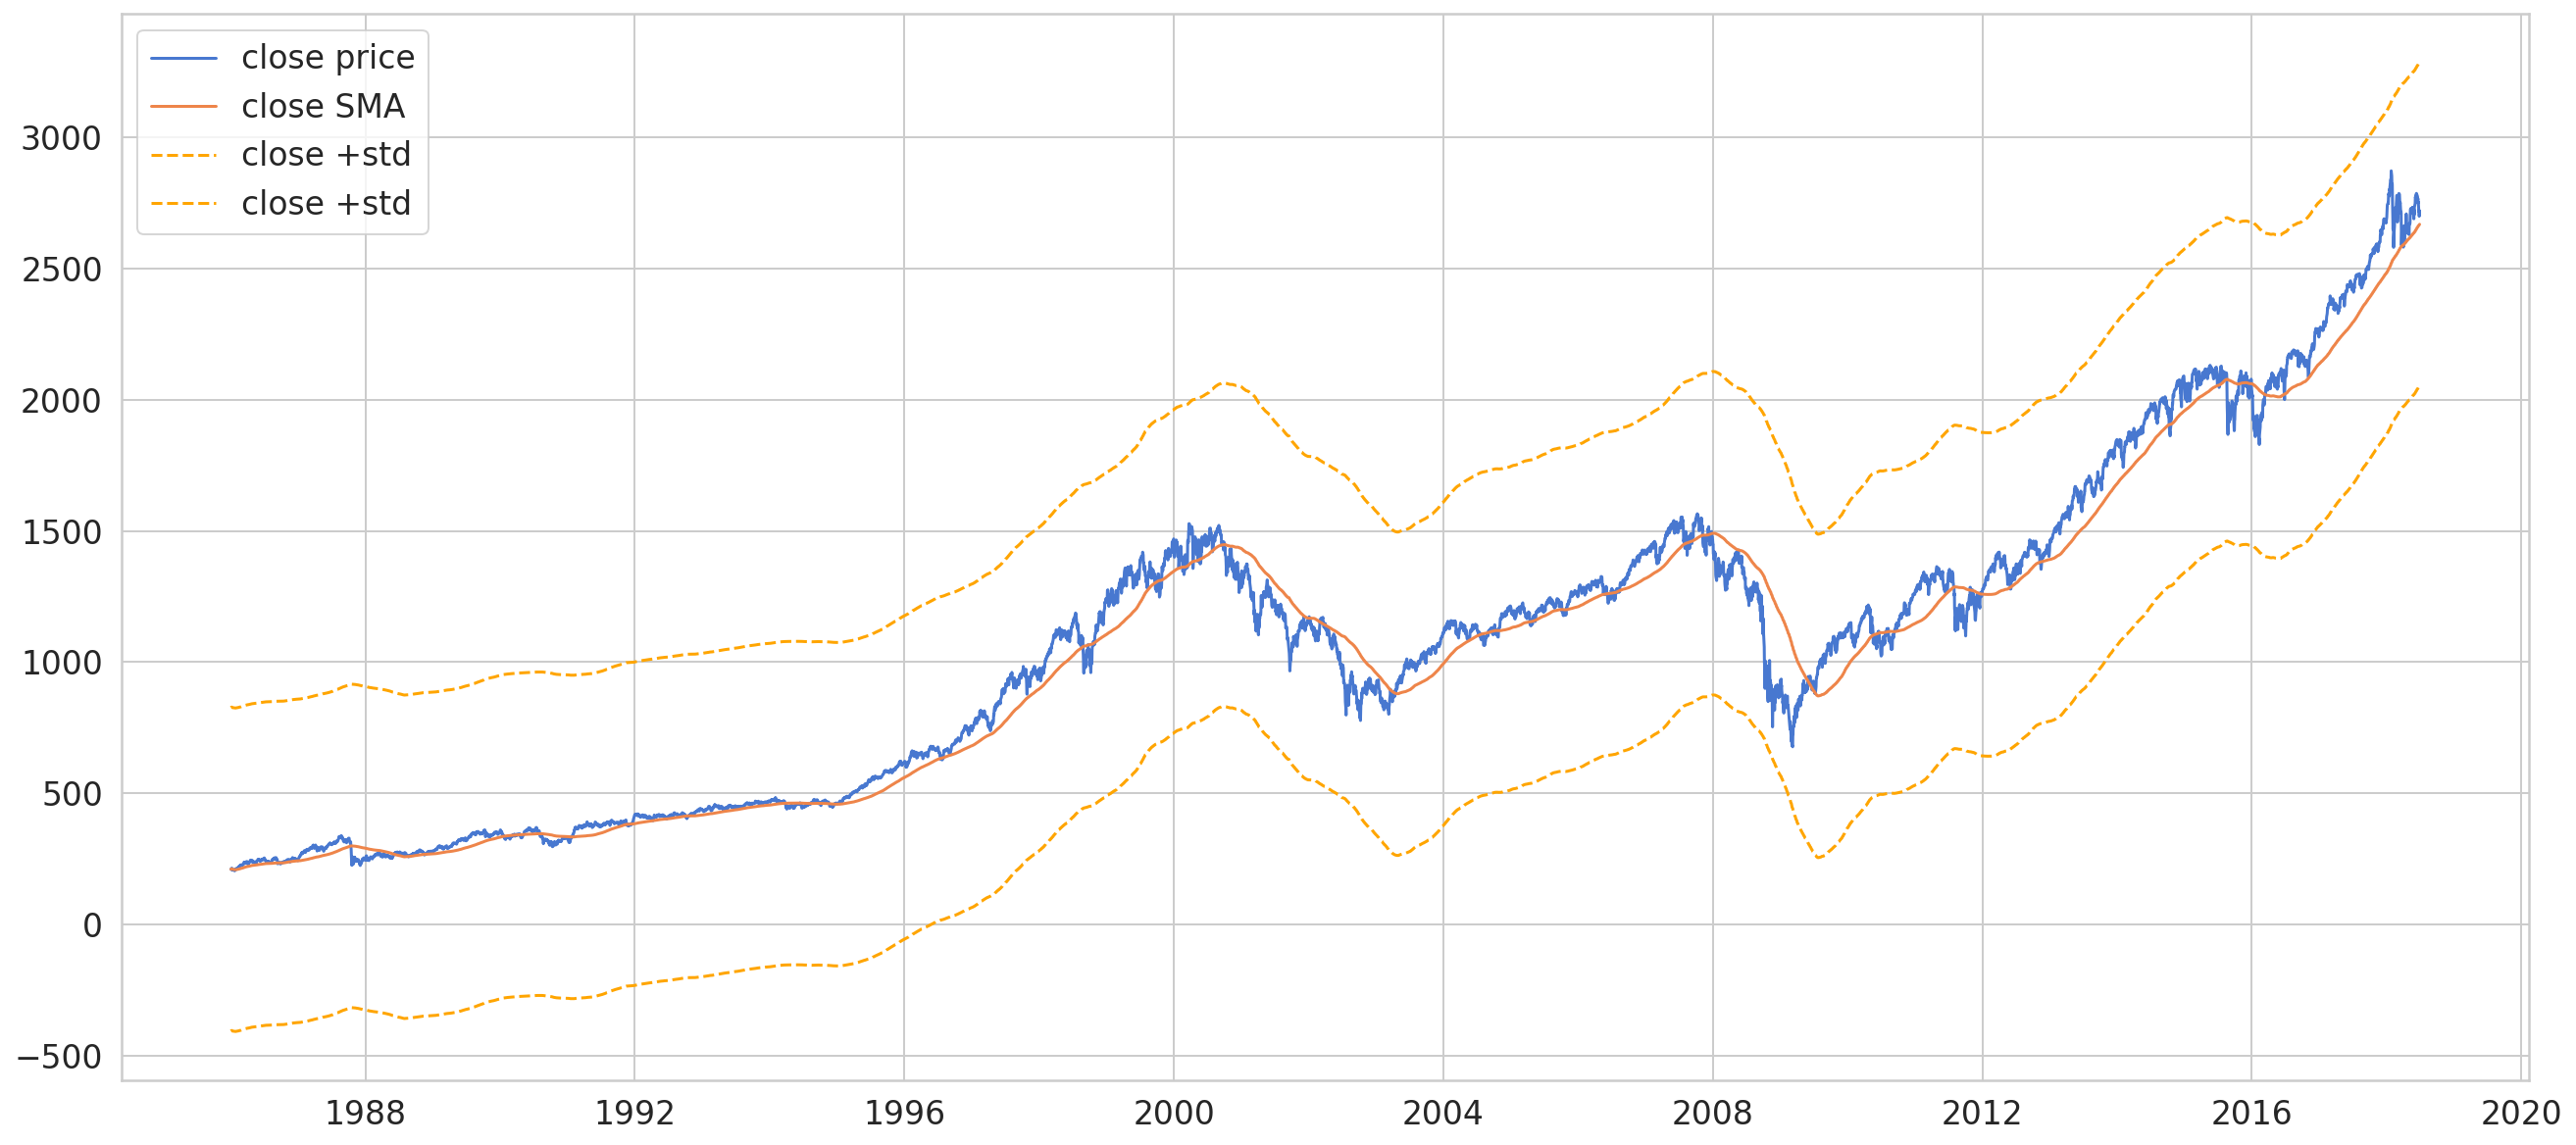

In [6]:
rcParams['figure.figsize'] = 22, 10
import matplotlib.pyplot as plt

plt.plot(df.index,df["close"], label='close price')
plt.plot(df.index,df["SMA_Temp"] ,label='close SMA')

plt.plot(df.index,df["SMA_Temp"]+ std_x_train,label='close +std' , color="orange",linestyle='dashed')
plt.plot(df.index,df["SMA_Temp"]- std_x_train,label='close +std', color="orange",linestyle='dashed')

plt.legend();

In [7]:
train_size = int(len(df) * 0.80)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(6553, 2) (1639, 2)


In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['close']])

train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [9]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

### look 30 days back for prediction

In [11]:
TIME_STEPS = 30

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[['close']], train.close, TIME_STEPS)
X_test, y_test = create_dataset(test[['close']], test.close, TIME_STEPS)

print(X_train.shape)

(6523, 30, 1)


In [ ]:
  ''' inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)

    '''

" inputs = Input(shape=(X.shape[1], X.shape[2]))\n  L1 = LSTM(16, activation='relu', return_sequences=True, \n            kernel_regularizer=regularizers.l2(0.00))(inputs)\n  L2 = LSTM(4, activation='relu', return_sequences=False)(L1)\n  L3 = RepeatVector(X.shape[1])(L2)\n  L4 = LSTM(4, activation='relu', return_sequences=True)(L3)\n  L5 = LSTM(16, activation='relu', return_sequences=True)(L4)\n  output = TimeDistributed(Dense(X.shape[2]))(L5)    \n  model = Model(inputs=inputs, outputs=output)\n\n  "

## create the model

### option 1:

In [ ]:
'''
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2]),activation='relu'
))
model.add(keras.layers.Dropout(rate=0.2))

#model.add(keras.layers.LSTM(units=16, activation='relu'))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))

#model.add(keras.layers.LSTM(units=16, return_sequences=True,activation='relu'))
model.add(keras.layers.LSTM(units=64, return_sequences=True,activation='relu'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))

model.compile(loss='mae', optimizer='adam', metrics="accuracy")

'''

'\nmodel = keras.Sequential()\nmodel.add(keras.layers.LSTM(\n    units=64, \n    input_shape=(X_train.shape[1], X_train.shape[2]),activation=\'relu\'\n))\nmodel.add(keras.layers.Dropout(rate=0.2))\n\n#model.add(keras.layers.LSTM(units=16, activation=\'relu\'))\nmodel.add(keras.layers.RepeatVector(n=X_train.shape[1]))\n\n#model.add(keras.layers.LSTM(units=16, return_sequences=True,activation=\'relu\'))\nmodel.add(keras.layers.LSTM(units=64, return_sequences=True,activation=\'relu\'))\nmodel.add(keras.layers.Dropout(rate=0.2))\nmodel.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))\n\nmodel.compile(loss=\'mae\', optimizer=\'adam\', metrics="accuracy")\n\n'

### option2:

In [61]:
model = keras.Sequential()

#encoder
model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.1))


#decoder
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.1))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))

model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_48 (LSTM)               (None, 64)                16896     
_________________________________________________________________
dropout_25 (Dropout)         (None, 64)                0         
_________________________________________________________________
repeat_vector_13 (RepeatVect (None, 30, 64)            0         
_________________________________________________________________
lstm_49 (LSTM)               (None, 30, 64)            33024     
_________________________________________________________________
dropout_26 (Dropout)         (None, 30, 64)            0         
_________________________________________________________________
time_distributed_12 (TimeDis (None, 30, 1)             65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________

In [63]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/20
184/184 [==============================] - 2s 9ms/step - loss: 0.1233 - val_loss: 0.1744
Epoch 2/20
184/184 [==============================] - 1s 6ms/step - loss: 0.1068 - val_loss: 0.1713
Epoch 3/20
184/184 [==============================] - 1s 6ms/step - loss: 0.0994 - val_loss: 0.1269
Epoch 4/20
184/184 [==============================] - 1s 6ms/step - loss: 0.0861 - val_loss: 0.1337
Epoch 5/20
184/184 [==============================] - 1s 6ms/step - loss: 0.0975 - val_loss: 0.1395
Epoch 6/20
184/184 [==============================] - 1s 6ms/step - loss: 0.1140 - val_loss: 0.1299
Epoch 7/20
184/184 [==============================] - 1s 6ms/step - loss: 0.1298 - val_loss: 0.1644
Epoch 8/20
184/184 [==============================] - 1s 6ms/step - loss: 0.1241 - val_loss: 0.2340
Epoch 9/20
184/184 [==============================] - 1s 6ms/step - loss: 0.1011 - val_loss: 0.1737
Epoch 10/20
184/184 [==============================] - 1s 6ms/step - loss: 0.1073 - val_loss: 0.1371

In [65]:
y_hat=model.predict(X_test)
y_hat.reshape(-1,30)
y_hat.shape

model.evaluate(X_test,y_test)

51/51 [==============================] - 0s 3ms/step - loss: 0.9267


0.9266932010650635

In [16]:
y_test.shape

(1609,)

## plot the loss vs. ecpochs

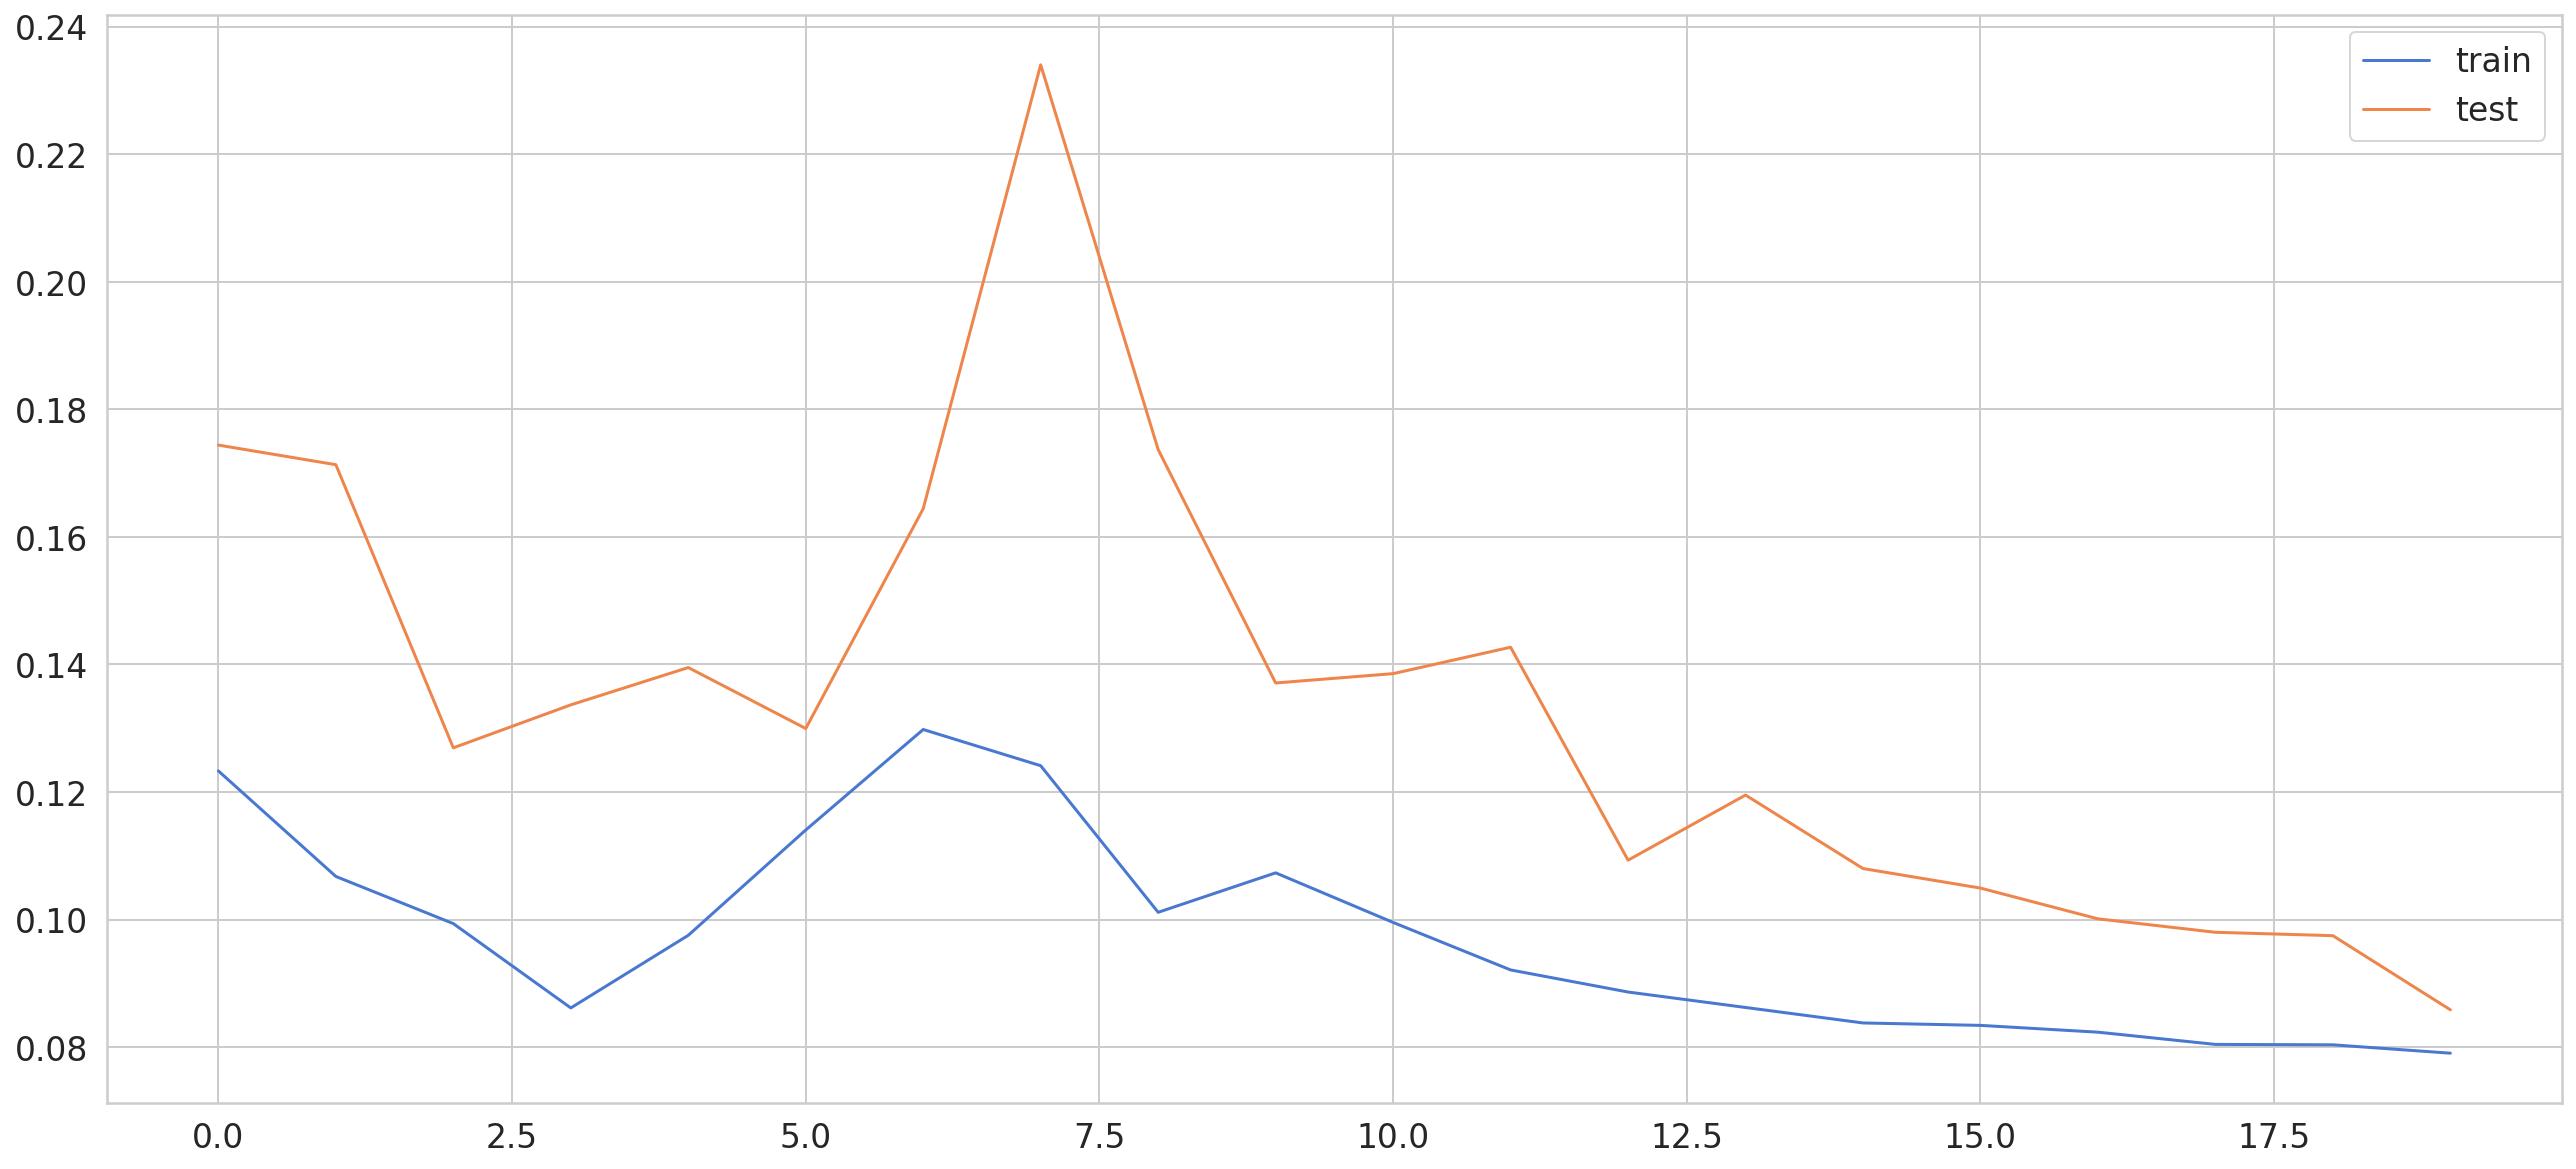

In [66]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

## calc the loss between ypred - ytest

In [67]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


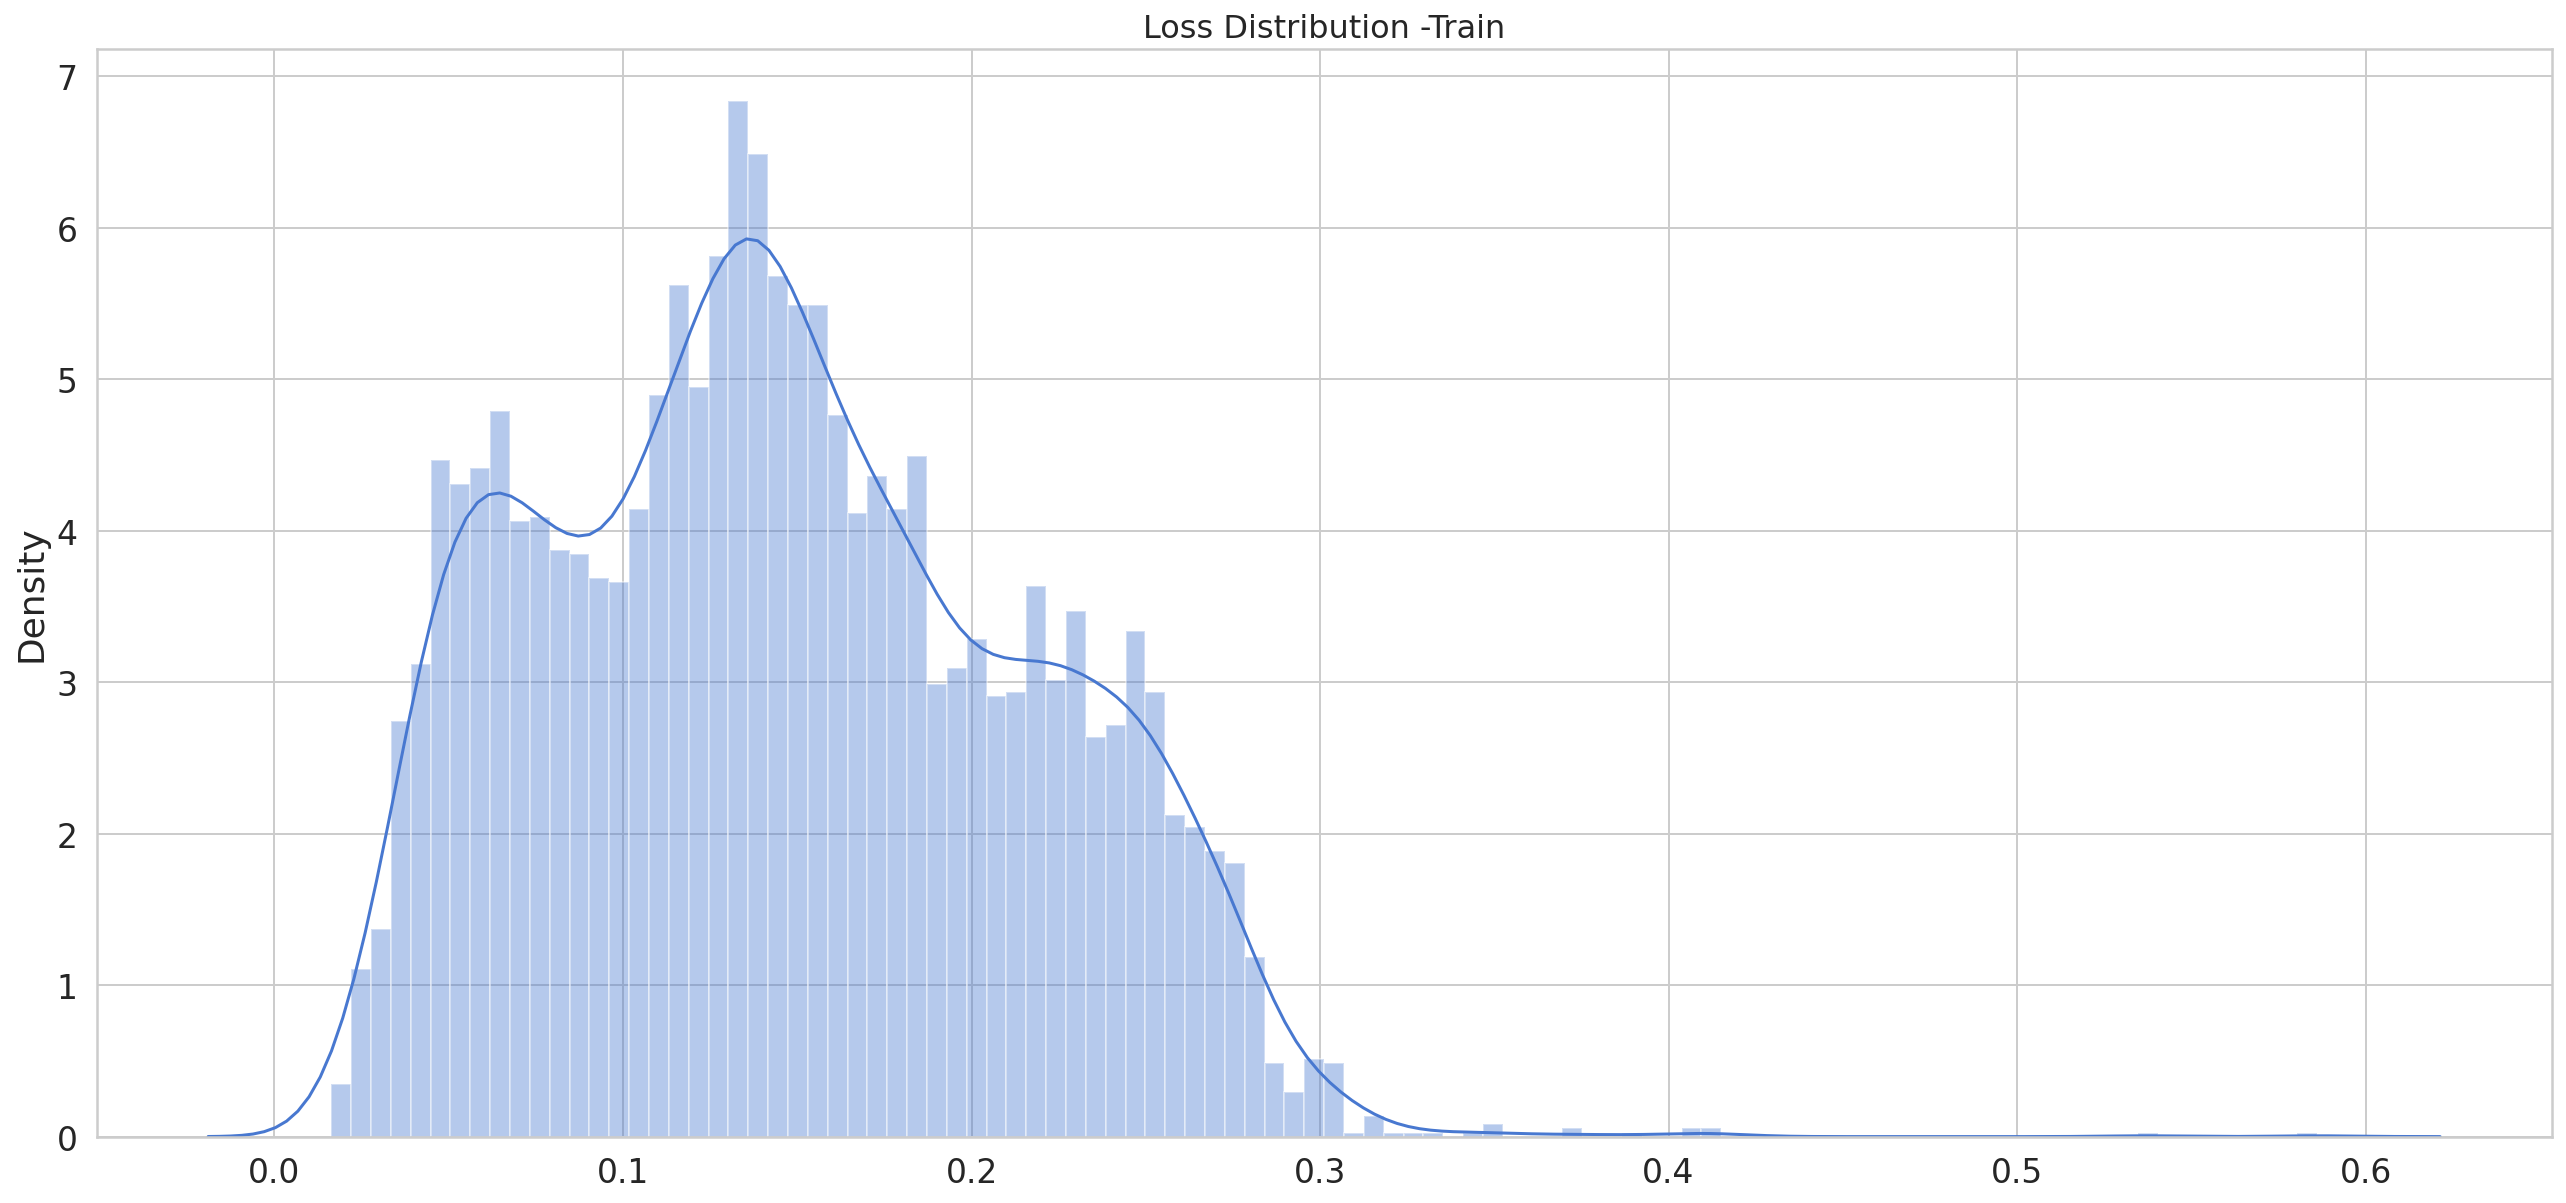

In [68]:
plt.title('Loss Distribution -Train', fontsize=16)
sns.distplot(train_mae_loss, bins=100, kde=True);

In [69]:
X_test_pred = model.predict(X_test)


test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


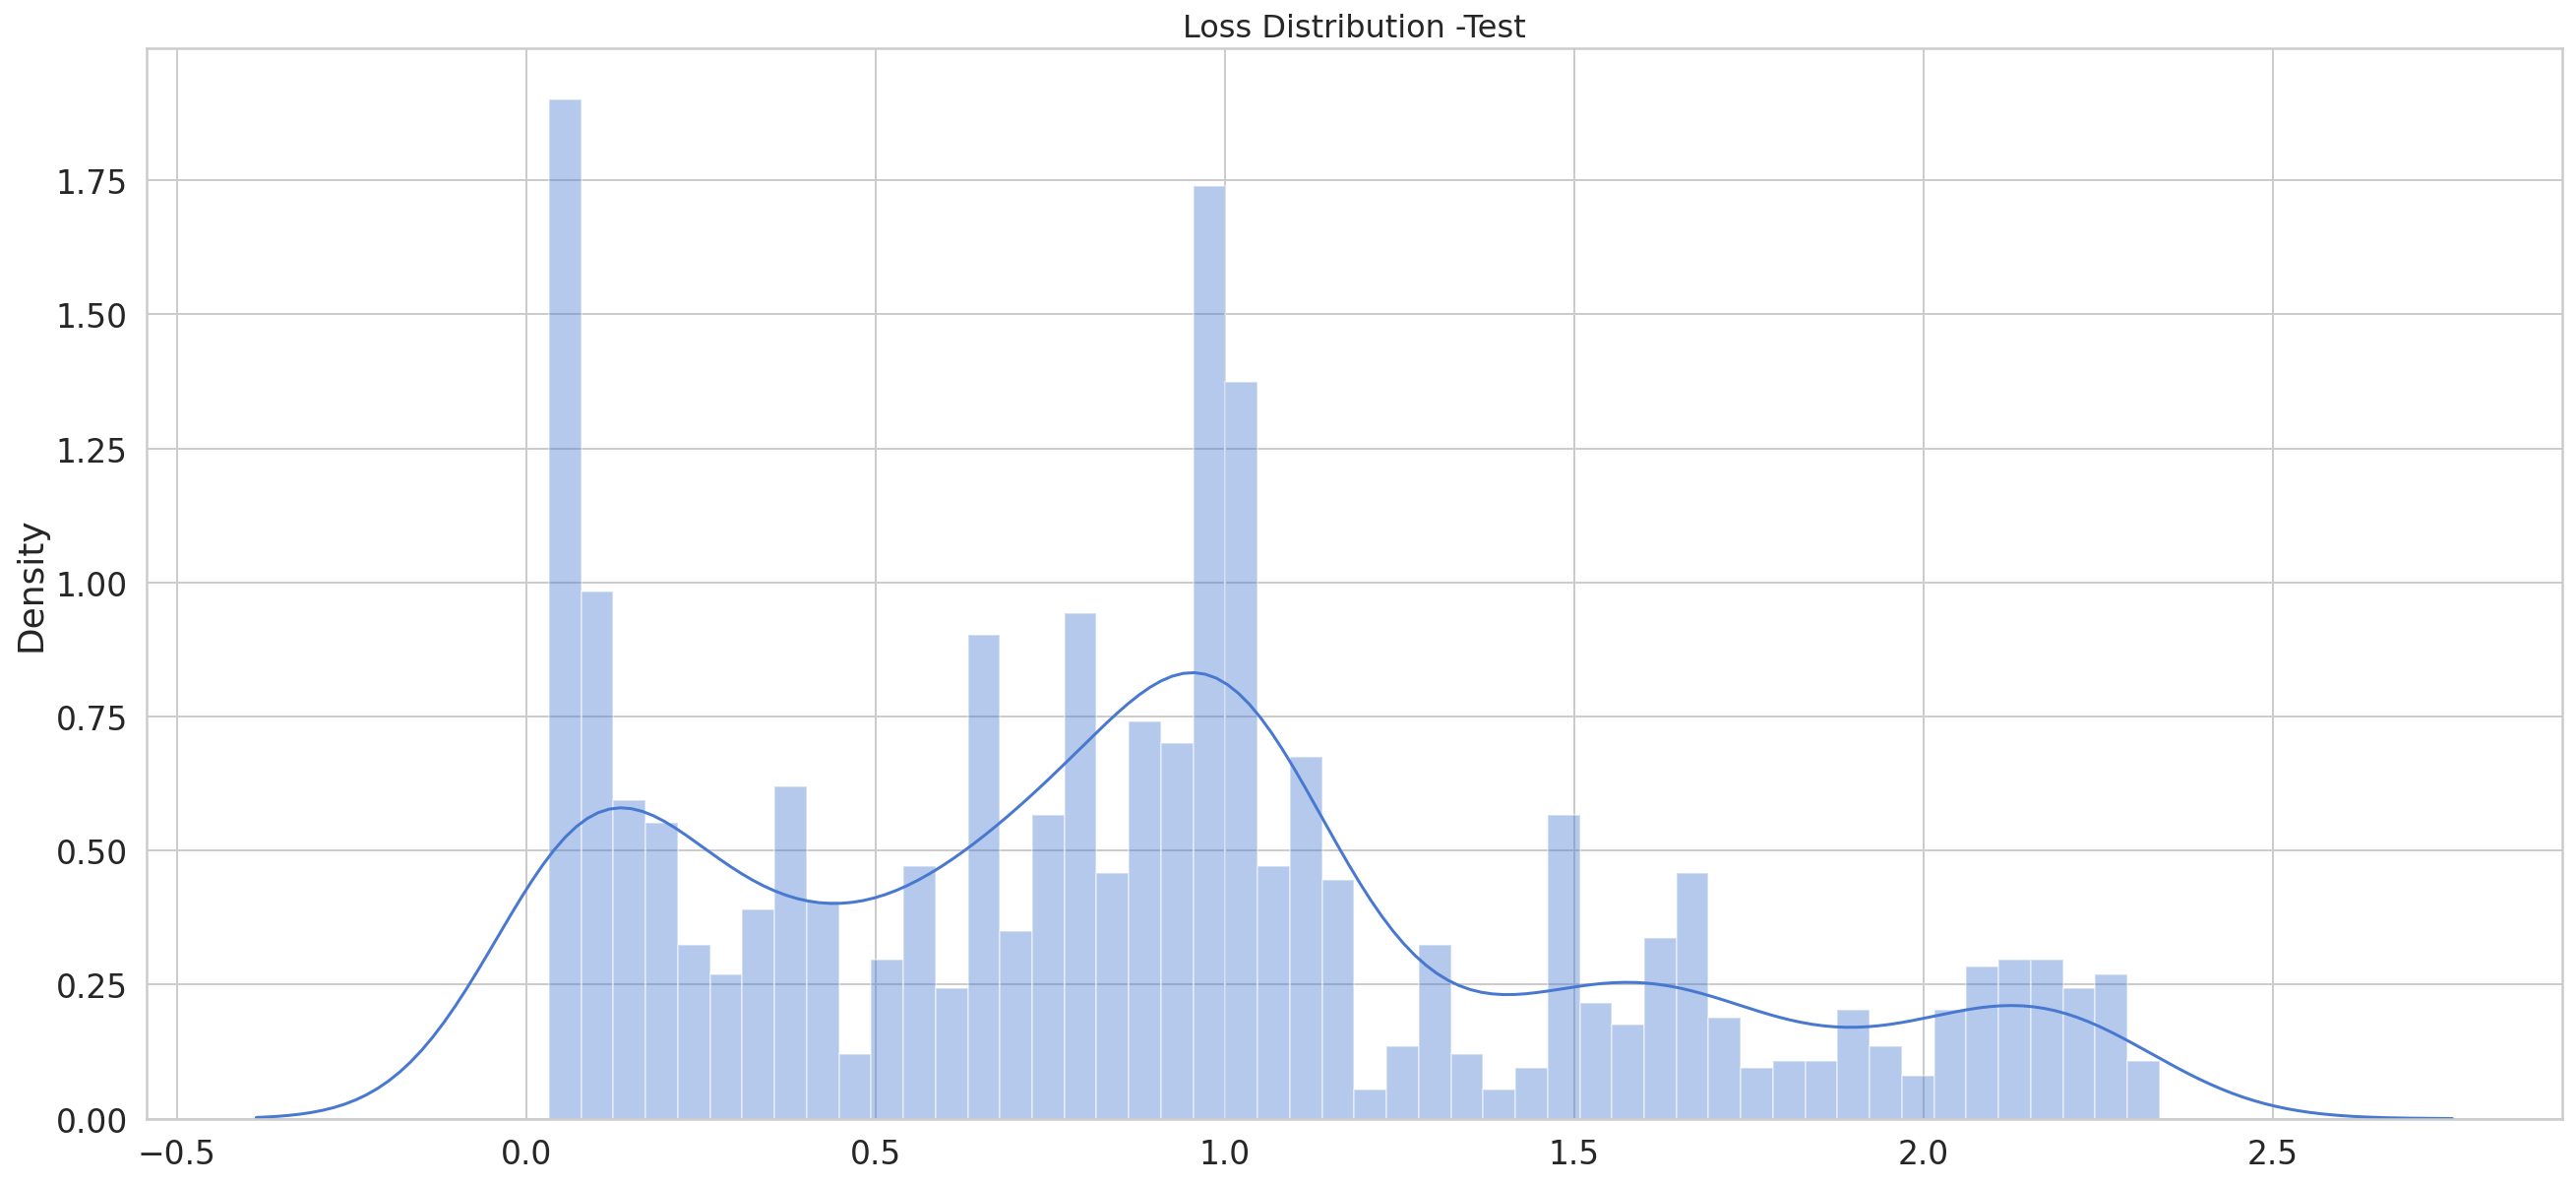

In [70]:
plt.title('Loss Distribution -Test', fontsize=16)
sns.distplot(test_mae_loss, bins=50, kde=True);

## calc threshold with std. deviation

In [71]:




test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss

#calculate threshold by std deviation *3

std_x_train=np.std(test_score_df.loss)*3
mean_x_train=np.mean(test_score_df.loss)

THRESHOLD = std_x_train

test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[TIME_STEPS:].close

THRESHOLD

1.8340983295007383

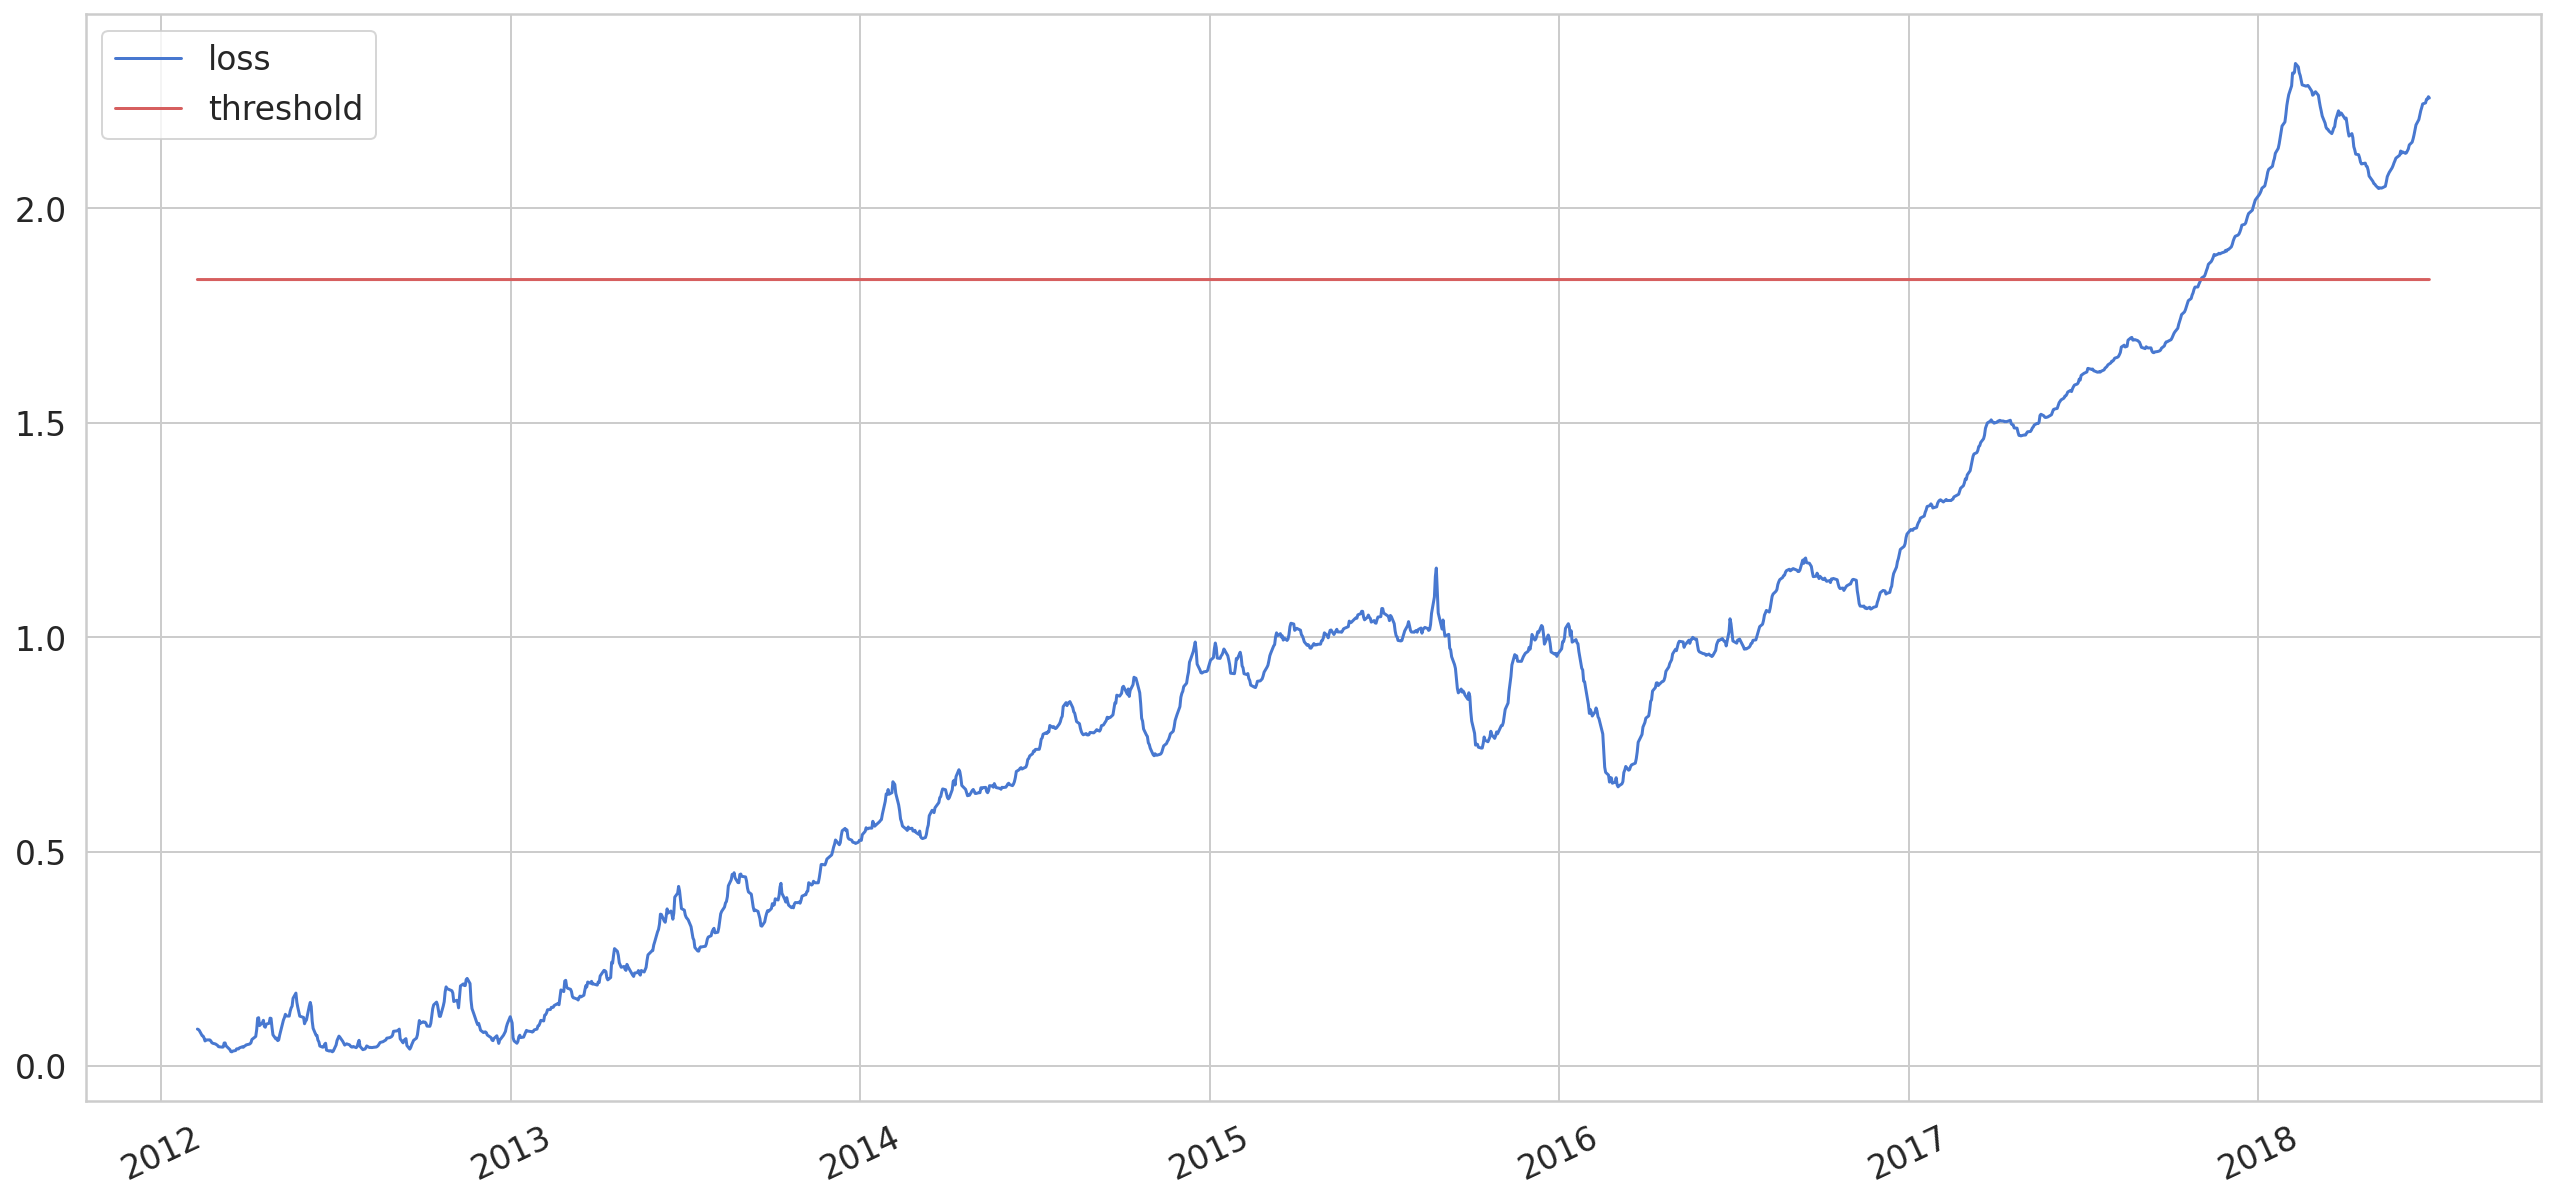

In [72]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold', color="r")
plt.xticks(rotation=25)
plt.legend();

## print and plot the anomalies

In [73]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head(30)

,loss,threshold,anomaly,close
date,,,,
2017-11-03,1.837921,1.834098,True,4.183519
2017-11-06,1.842250,1.834098,True,4.191404
2017-11-07,1.848126,1.834098,True,4.190230
2017-11-08,1.855279,1.834098,True,4.199193
2017-11-09,1.861088,1.834098,True,4.175802
2017-11-10,1.869646,1.834098,True,4.170242
2017-11-13,1.876160,1.834098,True,4.176329
2017-11-14,1.880376,1.834098,True,4.162022
2017-11-15,1.885650,1.834098,True,4.127871


In [80]:
anomalies_str=str(anomalies.count())

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


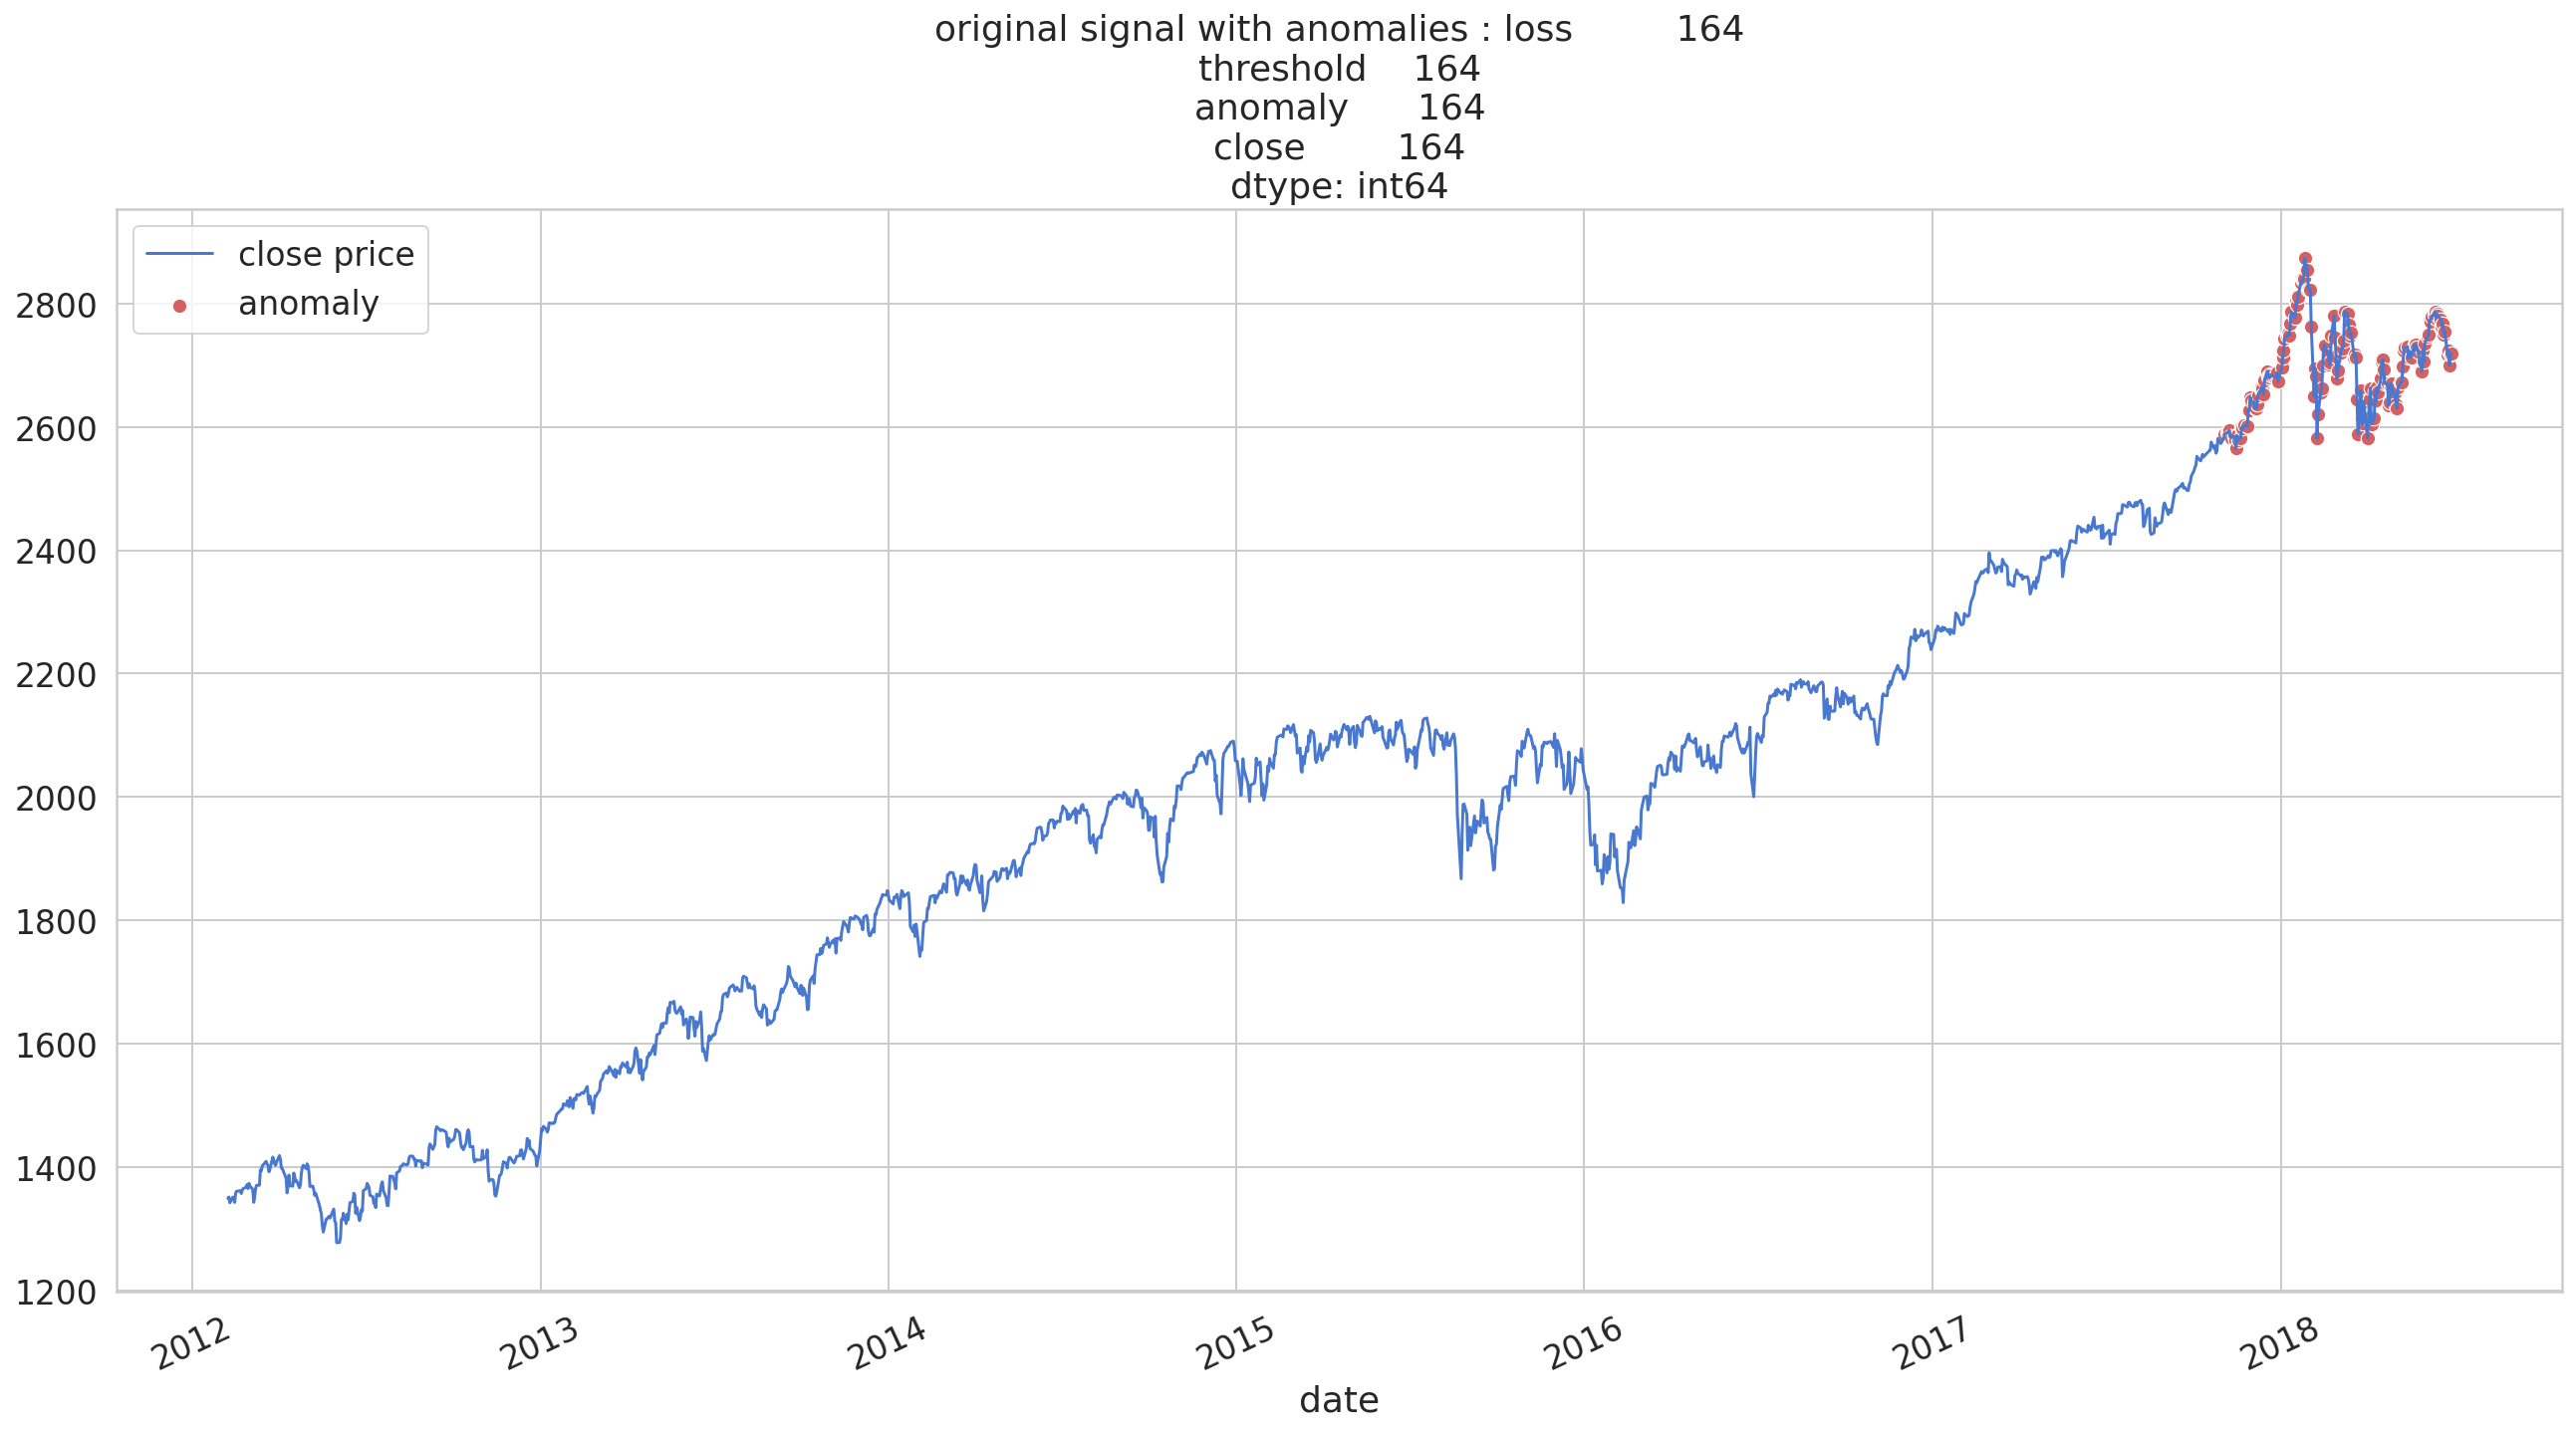

In [82]:
plt.plot(
  test[TIME_STEPS:].index, 
  scaler.inverse_transform(test[TIME_STEPS:].close), 
  label='close price'
);

sns.scatterplot(
  anomalies.index,
  scaler.inverse_transform(anomalies.close),
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.title('original signal with anomalies : '+anomalies_str)
plt.legend();